# Symphony runtime scalability analysis
July 5, 2021

In [1]:
# Import libraries
suppressPackageStartupMessages({
    library(tidyverse)
    library(data.table)
    library(matrixStats)
    library(patchwork)
    library(ggthemes)
    library(Matrix)
    library(ggplot2)
    library(plyr)
    library(dplyr)
    library(Seurat)
    library(ggrastr)
    library(ggpubr)
    require(scales)
})

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

## Make standard reference-sized datasets:

In [2]:
# set up the dataset
exprs_norm = readRDS("/data/srlab1/anathan/TBRU/data/analysis/exprs_norm_01.12.rds")
meta_data = readRDS("/data/srlab1/anathan/TBRU/data/analysis/meta_data_01.12.rds")

meta_data <- meta_data[meta_data$memTgate,]
meta_data$dummy <- 'A'

In [3]:
# Make reference datasets
for (n in c(20000, 50000, 100000, 250000, 500000)){
    if (n == 500000) {
        # use entire dataset
        idx_ref = sample(seq(1, nrow(meta_data)), n)
    } else if (n == 250000) {
        # limit to batches 12-35 (24 batches, 136 donors, 257581)
        idx_ref = which(meta_data$batch %in% c(12:35))
        idx_ref = sample(idx_ref, n)
    } else if (n == 100000) {
        # limit to batches 12-21 (58 donors, 107730 cells)
        idx_ref = which(meta_data$batch > 11 & meta_data$batch <= 21)
        idx_ref = sample(idx_ref, n)
    } else if (n == 50000) {
        # limit to batches 12-16 (30 donors, 56117 cells)
        idx_ref = which(meta_data$batch %in% c(12:16))
        idx_ref = sample(idx_ref, n)
    } else if (n == 20000) {
        # limit to batch 12, 13 (12 donors, 20685 cells)
        idx_ref = which(meta_data$batch %in% c(12, 13))
        idx_ref = sample(idx_ref, n)
    }
    ref_exp = exprs_norm[, idx_ref]
    ref_metadata = meta_data[idx_ref, ]
    saveRDS(ref_exp, paste0('benchmark_datasets/', 'ref_exp_', n, '.rds'))
    saveRDS(ref_metadata, paste0('benchmark_datasets/', 'ref_metadata_', n, '.rds'))
}

In [4]:
# Make query datasets
for (m in c(1000, 10000, 100000)) {
    if (m == 100000) {
        # limit to batches 1-11 (64 donors, 106658 cells)
        idx_query = which(meta_data$batch <= 11)
        idx_query = sample(idx_query, m)
    } else if (m == 10000) {
        # limit to batch 1 (6 donors, 10075 cells)
        idx_query = which(meta_data$batch <= 1)
        idx_query = sample(idx_query, m)
    } else if (m == 1000) {
        # limit to batch 1, donor 1 (2230 cells)
        idx_query = which(meta_data$batch <= 1 & meta_data$donor == 'M0007178-8')
        idx_query = sample(idx_query, m)
    }
    query_exp = exprs_norm[, idx_query]
    query_metadata = meta_data[idx_query, ]
    saveRDS(query_exp, paste0('benchmark_datasets/', 'query_exp_', m, '.rds'))
    saveRDS(query_metadata, paste0('benchmark_datasets/', 'query_metadata_', m, '.rds'))
}

To avoid a Seurat warning, we need to make sure that for the 500,000 cell reference dataset, we change the rownames so there are no duplicate rownames.

In [4]:
n = 5e+5
ref_5k = readRDS(paste0('benchmark_datasets/', 'ref_exp_', n, '.rds'))
meta_5k = readRDS(paste0('benchmark_datasets/', 'ref_metadata_', n, '.rds'))

In [5]:
colnames(ref_5k) = paste0(colnames(ref_5k), '_A')
meta_5k$cell_id = paste0(meta_5k$cell_id, '_A')
ref_5k[1:5, 1:5]
meta_5k %>% head()

5 x 5 sparse Matrix of class "dgCMatrix"
            CCACCATGTTGCCGAC-7_A CCTAACCAGCTTTCCC-18_A TGTAACGCATGTGTCA-30_A
MIR1302-2HG                    .                     .                     .
FAM138A                        .                     .                     .
OR4F5                          .                     .                     .
AL627309.1                     .                     .                     .
AL627309.3                     .                     .                     .
            GTCGAATTCAACGCTA-21_A TGCGACGTCTTAGCAG-38_A
MIR1302-2HG                     .                     .
FAM138A                         .                     .
OR4F5                           .                     .
AL627309.1                      .                     .
AL627309.3                      .                     .

cell_id,dummy,nUMI,nGene,percent_mito,demux,donor,id,qc,batch,correct,memTgate
<chr>,<chr>,<dbl>,<int>,<dbl>,<lgl>,<chr>,<chr>,<lgl>,<dbl>,<lgl>,<lgl>
CCACCATGTTGCCGAC-7_A,A,7455,2218,0.06116700,TRUE,M0015237-2,M0015237-2-7,TRUE,7,TRUE,TRUE
CCTAACCAGCTTTCCC-18_A,A,6164,2193,0.06164828,TRUE,M0011982-7,M0011982-7-18,TRUE,18,TRUE,TRUE
TGTAACGCATGTGTCA-30_A,A,6710,1872,0.07242921,TRUE,M0007803-1,M0007803-1-30,TRUE,30,TRUE,TRUE
GTCGAATTCAACGCTA-21_A,A,7481,1744,0.09731319,TRUE,M0009413-7,M0009413-7-21,TRUE,21,TRUE,TRUE
TGCGACGTCTTAGCAG-38_A,A,6479,1910,0.05726192,TRUE,M0012428-0,M0012428-0-38,TRUE,38,TRUE,TRUE
TGTTGGAAGTTGTAAG-44_A,A,4416,1200,0.08401268,TRUE,M0019109-9,M0019109-9-44,TRUE,44,TRUE,TRUE


In [6]:
saveRDS(ref_5k, paste0('benchmark_datasets/', 'ref_exp_', n, '.rds'))
saveRDS(meta_5k, paste0('benchmark_datasets/', 'ref_metadata_', n, '.rds'))

## Run Symphony/Harmony experiments on standard reference-sized datasets:

In [7]:
# Build and submit the scripts
ref_sizes = c(20000, 50000, 100000, 250000, 500000)
query_sizes = c(1000, 10000, 100000)

In [14]:
avoid_clusters = '-R \"select[hname!=cn044]\" -R \"select[hname!=cn045]\" -R \"select[hname!=cn001]\" -R \"select[hname!=cn002]\" -R \"select[hname!=cn003]\" -R \"select[hname!=cn004]\" -R \"select[hname!=cn005]\"'
for (r in ref_sizes) {
    for (q in query_sizes) {
        prefix = '/data/srlab2/jkang/symphony_reproducibility/runtime/results/'
        
        filename = paste0(prefix, 'symphony_', 'q=', q, '_r=', r)
        p = paste('bsub', avoid_clusters, '-q big-multi -n 4 -o ', filename, ' -M 64000 -R \'rusage[mem=64000]\' "Rscript run_symphony.R', q, r, "\"")
        print(p)
        system(p)
            
        filename = paste0(prefix, 'harmony_', 'q=', q, '_r=', r)
        p = paste('bsub', avoid_clusters, '-q big-multi -n 4 -o ', filename, ' -M 64000 -R \'rusage[mem=64000]\' "Rscript run_harmony.R', q, r, "\"")
        print(p)
        system(p)
    }
}

[1] "bsub -R \"select[hname!=cn044]\" -R \"select[hname!=cn045]\" -R \"select[hname!=cn001]\" -R \"select[hname!=cn002]\" -R \"select[hname!=cn003]\" -R \"select[hname!=cn004]\" -R \"select[hname!=cn005]\" -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/results/symphony_q=1000_r=20000  -M 64000 -R 'rusage[mem=64000]' \"Rscript run_symphony.R 1000 20000 \""
[1] "bsub -R \"select[hname!=cn044]\" -R \"select[hname!=cn045]\" -R \"select[hname!=cn001]\" -R \"select[hname!=cn002]\" -R \"select[hname!=cn003]\" -R \"select[hname!=cn004]\" -R \"select[hname!=cn005]\" -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/results/harmony_q=1000_r=20000  -M 64000 -R 'rusage[mem=64000]' \"Rscript run_harmony.R 1000 20000 \""
[1] "bsub -R \"select[hname!=cn044]\" -R \"select[hname!=cn045]\" -R \"select[hname!=cn001]\" -R \"select[hname!=cn002]\" -R \"select[hname!=cn003]\" -R \"select[hname!=cn004]\" -R \"select[hname!=cn005]\" -q big-multi -n 4 -o  /dat

## Run Seurat experiments on standard reference-sized datasets:

In [2]:
# Build and submit the scripts
ref_sizes = c(20000, 50000, 100000, 250000, 500000)
query_sizes = c(1000, 10000, 100000)

Run Seurat de novo experiments

In [3]:
avoid_clusters = '-R \"select[hname!=cn044]\" -R \"select[hname!=cn045]\" -R \"select[hname!=cn001]\" -R \"select[hname!=cn002]\" -R \"select[hname!=cn003]\" -R \"select[hname!=cn004]\" -R \"select[hname!=cn005]\"'
for (r in ref_sizes) {
    for (q in query_sizes) {
        prefix = '/data/srlab2/jkang/symphony_reproducibility/runtime/results/'
        filename = paste0(prefix, 'seurat_de_novo_', 'q=', q, '_r=', r,'_output_120GB')
        p = paste('bsub', avoid_clusters, '-q big-multi -n 4 -o ', filename, 
                  '-M 120000 -R \'rusage[mem=120000]\' "Rscript run_Seurat_de_novo.R', q, r, "\"")
        print(p)
        system(p)
    }
}

[1] "bsub -R \"select[hname!=cn044]\" -R \"select[hname!=cn045]\" -R \"select[hname!=cn001]\" -R \"select[hname!=cn002]\" -R \"select[hname!=cn003]\" -R \"select[hname!=cn004]\" -R \"select[hname!=cn005]\" -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/results/seurat_de_novo_q=1000_r=20000_output_120GB -M 120000 -R 'rusage[mem=120000]' \"Rscript run_Seurat_de_novo.R 1000 20000 \""
[1] "bsub -R \"select[hname!=cn044]\" -R \"select[hname!=cn045]\" -R \"select[hname!=cn001]\" -R \"select[hname!=cn002]\" -R \"select[hname!=cn003]\" -R \"select[hname!=cn004]\" -R \"select[hname!=cn005]\" -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/results/seurat_de_novo_q=10000_r=20000_output_120GB -M 120000 -R 'rusage[mem=120000]' \"Rscript run_Seurat_de_novo.R 10000 20000 \""
[1] "bsub -R \"select[hname!=cn044]\" -R \"select[hname!=cn045]\" -R \"select[hname!=cn001]\" -R \"select[hname!=cn002]\" -R \"select[hname!=cn003]\" -R \"select[hname!=cn004]\

Run Seurat reference mapping experiments

In [4]:
for (r in ref_sizes) {
    for (q in query_sizes) {
        prefix = '/data/srlab2/jkang/symphony_reproducibility/runtime/results/'
        filename = paste0(prefix, 'seurat_ref_mapping_', 'q=', q, '_r=', r,'_output_120GB')
        p = paste('bsub', avoid_clusters, '-q big-multi -n 4 -o ', filename, 
                  '-M 120000 -R \'rusage[mem=120000]\' "Rscript run_Seurat_ref_mapping.R', q, r, "\"")
        print(p)
        system(p)
    }
}

[1] "bsub -R \"select[hname!=cn044]\" -R \"select[hname!=cn045]\" -R \"select[hname!=cn001]\" -R \"select[hname!=cn002]\" -R \"select[hname!=cn003]\" -R \"select[hname!=cn004]\" -R \"select[hname!=cn005]\" -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/results/seurat_ref_mapping_q=1000_r=20000_output_120GB -M 120000 -R 'rusage[mem=120000]' \"Rscript run_Seurat_ref_mapping.R 1000 20000 \""
[1] "bsub -R \"select[hname!=cn044]\" -R \"select[hname!=cn045]\" -R \"select[hname!=cn001]\" -R \"select[hname!=cn002]\" -R \"select[hname!=cn003]\" -R \"select[hname!=cn004]\" -R \"select[hname!=cn005]\" -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/results/seurat_ref_mapping_q=10000_r=20000_output_120GB -M 120000 -R 'rusage[mem=120000]' \"Rscript run_Seurat_ref_mapping.R 10000 20000 \""
[1] "bsub -R \"select[hname!=cn044]\" -R \"select[hname!=cn045]\" -R \"select[hname!=cn001]\" -R \"select[hname!=cn002]\" -R \"select[hname!=cn003]\" -R \"selec

## View results

Print Harmony/Symphony results

In [3]:
for (file in list.files('results', pattern = 'ony')) {
    message(file)
    outfile = file(paste0('results/', file) , open="r")
    lines = readLines(outfile)
    idx = grep("elapsed", lines)
    for (i in idx){
        #print(lines[i])
        print(lines[i+1])
    }
    close(outfile)
}

harmony_q=1000_r=1e+05



[1] "3104.840 2617.926  391.786 "


harmony_q=1000_r=20000



[1] " 231.490 1137.129  167.558 "


harmony_q=1000_r=250000



[1] "23318.019 49247.307  7058.002 "


harmony_q=1000_r=50000



[1] " 875.473 3219.839  490.889 "


harmony_q=1000_r=5e+05



[1] "68907.152 68469.688  8895.052 "


harmony_q=10000_r=1e+05



[1] "4574.956 9967.839 1459.878 "


harmony_q=10000_r=20000



[1] "331.626 809.306  67.431 "


harmony_q=10000_r=250000



[1] "22812.251 23330.200  4117.026 "


harmony_q=10000_r=50000



[1] " 930.345 3144.304  493.657 "


harmony_q=10000_r=5e+05



[1] "62669.40 51303.92 10243.75 "


harmony_q=1e+05_r=1e+05



[1] "10248.503  6922.243  1074.483 "


harmony_q=1e+05_r=20000



[1] "4028.876 3501.948  512.148 "


harmony_q=1e+05_r=250000



[1] "37760.21 65999.72 10031.27 "


harmony_q=1e+05_r=50000



[1] " 8498.975 15922.982  2323.836 "


harmony_q=1e+05_r=5e+05



[1] " 63138.99 104816.75  16520.88 "


symphony_q=1000_r=1e+05



[1] "4125.082 9874.594 1411.927 "
[1] "  0.090   0.099   0.082 "


symphony_q=1000_r=20000



[1] "313.213 909.224  61.667 "
[1] "  0.131   0.226   0.056 "


symphony_q=1000_r=250000



[1] "22975.105 35280.979  4374.974 "
[1] "  0.085   0.149   0.070 "


symphony_q=1000_r=50000



[1] " 747.498 2764.156  419.600 "
[1] "  0.105   0.752   0.163 "


symphony_q=1000_r=5e+05



[1] "56293.85 63397.76 21093.27 "
[1] "  0.156   0.449   0.195 "


symphony_q=10000_r=1e+05



[1] "4238.919 8447.921  990.855 "
[1] "  2.346   7.568   1.382 "


symphony_q=10000_r=20000



[1] " 240.897 1208.561  177.539 "
[1] "  2.577  13.019   2.249 "


symphony_q=10000_r=250000



[1] "22451.697 47380.134  6775.721 "
[1] "  2.262   9.606   1.715 "


symphony_q=10000_r=50000



[1] " 788.652 2892.818  447.894 "
[1] "  2.171  10.532   1.996 "


symphony_q=10000_r=5e+05



[1] "64057.42 52813.83 10189.41 "
[1] "  2.354   4.734   1.180 "


symphony_q=1e+05_r=1e+05



[1] "3647.083 3469.485  485.216 "
[1] "118.953  43.947  13.401 "


symphony_q=1e+05_r=20000



[1] " 238.329 1196.295  173.493 "
[1] "160.694 297.555  43.261 "


symphony_q=1e+05_r=250000



[1] "21247.73 22944.27  3972.34 "
[1] "144.423 177.511  31.683 "


symphony_q=1e+05_r=50000



[1] " 898.936 1563.269  163.667 "
[1] "116.035  44.096  13.535 "


symphony_q=1e+05_r=5e+05



[1] " 63567.92 107769.19  16781.98 "
[1] "163.347 320.969  46.042 "


Print Seurat results

In [4]:
for (file in list.files('results', pattern = 'seurat')) {
    message(file)
    outfile = file(paste0('results/', file) , open="r")
    lines = readLines(outfile)
    idx = grep("elapsed|Error:|spat|Annoy|dupli|alloc|killed", lines) # possible errors
    for (i in idx){
        print(lines[i])
        print(lines[i+1])
    }
    close(outfile)
}

seurat_de_novo_q=1000_r=1e+05_output_120GB



[1] "Error: cannot allocate vector of size 20.8 Gb"
[1] "Timing stopped at: 2.105e+04 9760 1.829e+04"
[1] "system call failed: Cannot allocate memory "
[1] NA


seurat_de_novo_q=1000_r=20000_output_120GB



[1] "    user   system  elapsed "
[1] "1139.630  560.633  894.035 "


seurat_de_novo_q=1000_r=250000_output_120GB



[1] "Calls: system.time ... FindWeights -> NNHelper -> do.call -> AnnoyNN -> AnnoySearch"
[1] "In addition: There were 50 or more warnings (use warnings() to see the first 50)"


seurat_de_novo_q=1000_r=50000_output_120GB



[1] "    user   system  elapsed "
[1] "7842.424 2911.147 6926.435 "


seurat_de_novo_q=1000_r=5e+05_output_120GB



[1] "Calls: system.time ... FindWeights -> NNHelper -> do.call -> AnnoyNN -> AnnoySearch"
[1] "In addition: There were 50 or more warnings (use warnings() to see the first 50)"


seurat_de_novo_q=10000_r=1e+05_output_120GB



[1] "system call failed: Cannot allocate memory "
[1] NA


seurat_de_novo_q=10000_r=20000_output_120GB



[1] "    user   system  elapsed "
[1] "2259.466 1006.484 1874.398 "


seurat_de_novo_q=10000_r=250000_output_120GB



[1] "Calls: system.time ... FindWeights -> NNHelper -> do.call -> AnnoyNN -> AnnoySearch"
[1] "In addition: There were 50 or more warnings (use warnings() to see the first 50)"


seurat_de_novo_q=10000_r=50000_output_120GB



[1] "Error: cannot allocate vector of size 22.9 Gb"
[1] "Timing stopped at: 9272 3432 8090"
[1] "system call failed: Cannot allocate memory "
[1] NA


seurat_de_novo_q=10000_r=5e+05_output_120GB



[1] "TERM_OWNER: job killed by owner."
[1] "Exited with exit code 1."


seurat_de_novo_q=1e+05_r=1e+05_output_120GB



[1] "system call failed: Cannot allocate memory "
[1] NA


seurat_de_novo_q=1e+05_r=20000_output_120GB



[1] "Error: cannot allocate vector of size 19.6 Gb"
[1] "Timing stopped at: 3.02e+04 1.487e+04 2.659e+04"


seurat_de_novo_q=1e+05_r=250000_output_120GB



[1] "Calls: system.time ... FindWeights -> NNHelper -> do.call -> AnnoyNN -> AnnoySearch"
[1] "In addition: There were 50 or more warnings (use warnings() to see the first 50)"


seurat_de_novo_q=1e+05_r=50000_output_120GB



[1] "system call failed: Cannot allocate memory "
[1] NA


seurat_de_novo_q=1e+05_r=5e+05_output_120GB



[1] "Error: cannot allocate vector of size 89.1 Mb"
[1] "Timing stopped at: 8.771e+04 4.542e+04 6.838e+04"


seurat_ref_mapping_q=1000_r=1e+05_output_120GB



[1] "Error: cannot allocate vector of size 7.9 Gb"
[1] "Timing stopped at: 2.174e+04 8613 2.663e+04"
[1] "system call failed: Cannot allocate memory "
[1] NA


seurat_ref_mapping_q=1000_r=20000_output_120GB



[1] "   user  system elapsed "
[1] "985.950 434.154 754.823 "
[1] "   user  system elapsed "
[1] " 18.703   3.551  19.963 "


seurat_ref_mapping_q=1000_r=250000_output_120GB



[1] "Calls: system.time ... FindWeights -> NNHelper -> do.call -> AnnoyNN -> AnnoySearch"
[1] "In addition: There were 50 or more warnings (use warnings() to see the first 50)"


seurat_ref_mapping_q=1000_r=50000_output_120GB



[1] "    user   system  elapsed "
[1] "6633.218 2591.625 5484.759 "
[1] "   user  system elapsed "
[1] " 45.663   5.991  49.384 "


seurat_ref_mapping_q=1000_r=5e+05_output_120GB



[1] "TERM_OWNER: job killed by owner."
[1] "Exited with exit code 1."


seurat_ref_mapping_q=10000_r=1e+05_output_120GB



[1] "Error: cannot allocate vector of size 7.9 Gb"
[1] "Timing stopped at: 2.147e+04 8581 2.627e+04"
[1] "system call failed: Cannot allocate memory "
[1] NA


seurat_ref_mapping_q=10000_r=20000_output_120GB



[1] "    user   system  elapsed "
[1] "1008.579  395.013  768.275 "
[1] "   user  system elapsed "
[1] "124.669  23.734 133.855 "


seurat_ref_mapping_q=10000_r=250000_output_120GB



[1] "Calls: system.time ... FindWeights -> NNHelper -> do.call -> AnnoyNN -> AnnoySearch"
[1] "In addition: There were 50 or more warnings (use warnings() to see the first 50)"


seurat_ref_mapping_q=10000_r=50000_output_120GB



[1] "    user   system  elapsed "
[1] "7264.555 2417.319 6080.779 "
[1] "   user  system elapsed "
[1] "294.155  41.013 321.077 "


seurat_ref_mapping_q=10000_r=5e+05_output_120GB



[1] "TERM_OWNER: job killed by owner."
[1] "Exited with exit code 1."


seurat_ref_mapping_q=1e+05_r=1e+05_output_120GB



[1] "Error: cannot allocate vector of size 15.6 Gb"
[1] "Timing stopped at: 2.217e+04 8590 1.885e+04"


seurat_ref_mapping_q=1e+05_r=20000_output_120GB



[1] "    user   system  elapsed "
[1] "1014.728  433.081  784.617 "
[1] "    user   system  elapsed "
[1] "1384.809  250.014 1486.463 "


seurat_ref_mapping_q=1e+05_r=250000_output_120GB



[1] "Calls: system.time ... FindWeights -> NNHelper -> do.call -> AnnoyNN -> AnnoySearch"
[1] "In addition: There were 50 or more warnings (use warnings() to see the first 50)"


seurat_ref_mapping_q=1e+05_r=50000_output_120GB



[1] "    user   system  elapsed "
[1] "6819.816 2613.429 5704.960 "
[1] "    user   system  elapsed "
[1] "3080.402  383.743 3323.411 "


seurat_ref_mapping_q=1e+05_r=5e+05_output_120GB



[1] "TERM_OWNER: job killed by owner."
[1] "Exited with exit code 1."


## Plot results (Make figure)

In [5]:
runtime = read.csv('runtime_plot.csv', header = TRUE)
runtime %>% head(3)

,Query_num_cells,Ref_num_cells,Method,reference.building,query.mapping,de.novo.integration
,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>
1,1000,20000,Symphony,61.667,0.056,167.558
2,1000,50000,Symphony,419.600,0.163,490.889
3,1000,100000,Symphony,1411.927,0.082,391.786


In [6]:
runtime_long = gather(runtime, func, elapsed_time, reference.building:de.novo.integration, factor_key = TRUE)
levels(runtime_long$func) = c('reference building', 'query mapping', 'de novo integration')
runtime_long$Query_num_cells_donors = as.factor(runtime_long$Query_num_cells)
levels(runtime_long$Query_num_cells_donors) = c('1,000; 1', '10,000; 6', '100,000; 64')
runtime_long$Method = as.factor(runtime_long$Method)
runtime_plot = na.omit(runtime_long)
runtime_plot$elapsed_min = runtime_plot$elapsed_time / 60
#runtime_plot

In [7]:
## Rename de novo integration methods
runtime_plot$Method_better = as.character(runtime_plot$Method)
runtime_plot$Method_better[which(runtime_plot$Method == 'Symphony' & runtime_plot$func == 'de novo integration')] = 'Harmony'
runtime_plot$Method_better[which(runtime_plot$Method == 'scArches' & runtime_plot$func == 'de novo integration')] = 'trVAE'

## Plot Symphony results only

png 
  2

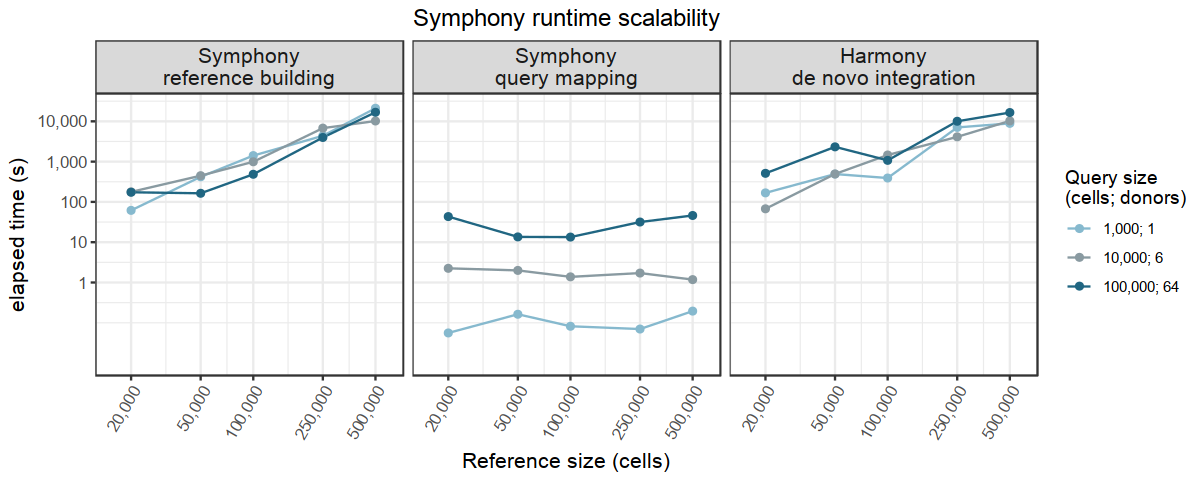

In [8]:
fig.size(4, 10)

pdf('figures/runtime_Symphony_Harmony.pdf', height=4, width=10,useDingbats = FALSE)

symphony_plot = runtime_plot[which(runtime_plot$Method == 'Symphony'),]
symphony_plot$longlabel = as.factor(paste0(symphony_plot$Method_better, '\n', symphony_plot$func))
symphony_plot$longlabel = forcats::fct_relevel(symphony_plot$longlabel, c('Symphony\nreference building', 
                                            'Symphony\nquery mapping', 'Harmony\nde novo integration'))

p = ggplot(data=symphony_plot, aes(x=Ref_num_cells, y=elapsed_time, 
                             color = Query_num_cells_donors)) +
    geom_line() + geom_point() +
    facet_wrap(~longlabel) +
    theme_bw() + scale_color_manual(values = c("#86B9CE", "#899AA1","#206682")) + 
    ylab('elapsed time (s)') + xlab('Reference size (cells)') + 
    labs(color = 'Query size \n(cells; donors)') +
    ggtitle('Symphony runtime scalability') +
    theme(axis.text.x = element_text(angle = 60, hjust = 1, size=10),
        axis.text.y = element_text(hjust = 1, size=10), strip.text.x = element_text(size=12),
        plot.title = element_text(hjust = 0.5, size = 14), axis.title=element_text(size=12)) +
    scale_x_continuous(trans = 'log2', labels = comma, 
        limits = c(15000, 600000), breaks = c(20000, 50000, 100000, 250000, 500000)) +
    scale_y_continuous(trans = 'log10', labels = comma_format(accuracy = 1), 
                       breaks = c(1, 10, 100, 1000, 10000), limits = c(0.01, 24000))
print(p)
dev.off()
p

## Plot reference building runtime for 3 tools

png 
  2

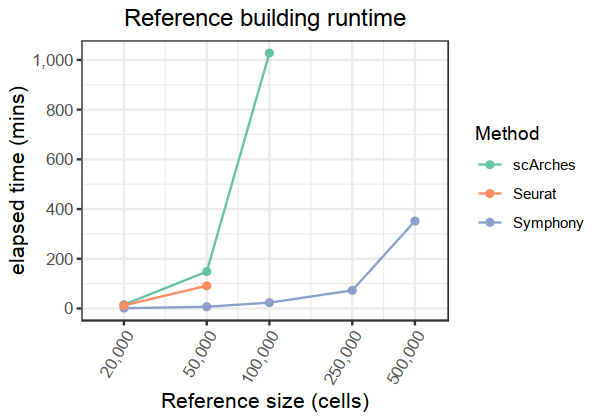

In [9]:
fig.size(3.5, 5)

runtime_ref_building = runtime_plot[which(runtime_plot$func == "reference building" &
                                         runtime_plot$Query_num_cells == 1000),]

pdf('figures/runtime_publish_refBuilding.pdf', height = 3.5, width = 5,useDingbats = FALSE)
p = ggplot(data=runtime_ref_building, 
           aes(x=Ref_num_cells, y=elapsed_min, color = Method)) +
    geom_line(aes(x=Ref_num_cells, y=elapsed_min, color = Method)) +
    geom_point() +
    theme_bw() + scale_color_brewer(palette = 'Set2') +
    ylab('elapsed time (mins)') + xlab('Reference size (cells)') + 
    ggtitle('Reference building runtime') +
    theme(axis.text.x = element_text(angle = 60, hjust = 1, size=10),
        axis.text.y = element_text(hjust = 1, size=10), strip.text.x = element_text(size=10),
        plot.title = element_text(hjust = 0.5, size = 14), axis.title=element_text(size=12)) +
    scale_x_continuous(trans = 'log2', labels = comma, 
        limits = c(15000, 600000), breaks = c(20000, 50000, 100000, 250000, 500000), ) +
    scale_y_continuous(labels = comma_format(accuracy = 1), breaks = c(0, 200, 400, 600, 800, 1000, 1200)) + 
    theme(strip.text.x = element_text(size = 12), strip.text.y = element_text(size = 11))
plot(p)
dev.off()
p

## Plot query mapping runtime for 3 tools

png 
  2

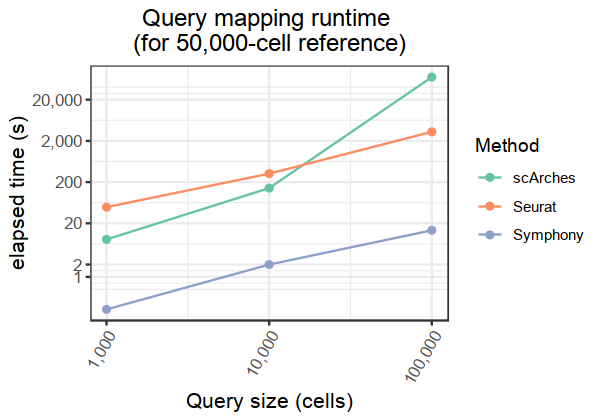

In [10]:
fig.size(3.5, 5)

runtime_query_mapping = runtime_plot[which(runtime_plot$func == "query mapping" &
                                         runtime_plot$Ref_num_cells == 50000),]

pdf('figures/runtime_publish_queryMapping.pdf', height = 3.5, width = 5,useDingbats = FALSE)

p = ggplot(data=runtime_query_mapping, aes(x = Query_num_cells, y = elapsed_time, color = Method)) +
    geom_line(aes(x = Query_num_cells, y = elapsed_time, color = Method)) +
    geom_point() +
    theme_bw() + scale_color_brewer(palette = 'Set2') +
    ylab('elapsed time (s)') + xlab('Query size (cells)') + 
    ggtitle('Query mapping runtime \n(for 50,000-cell reference)') +
    theme(axis.text.x = element_text(angle = 60, hjust = 1, size=10),
        axis.text.y = element_text(hjust = 1, size=10), strip.text.x = element_text(size=10),
        plot.title = element_text(hjust = 0.5, size = 14), axis.title=element_text(size=12)) +
    scale_x_continuous(trans = 'log10', labels = comma, breaks = c(1000, 10000, 100000)) + 
    scale_y_continuous(trans = 'log10', labels = comma_format(accuracy = 1), breaks = c(1, 2, 20, 200, 2000, 20000))
    #theme(strip.text.x = element_text(size = 12), strip.text.y = element_text(size = 11))
plot(p)
dev.off()
p

# Mapping parameter experiments
In this analysis, we will explore the effect of query num_cells and num_donors independently, as well as number of centroids and dimensions.

## Vary the num centroids and dimensions (k and d)

In [17]:
# vary num centroids (k)
for (k in c(25, 50, 100, 200, 400)) {
    prefix = '/data/srlab2/jkang/symphony_reproducibility/runtime/results_kd/'
    filename = paste0(prefix, 'symphony_', 'k=', k, '_d=', 20)
    p = paste('bsub -q big-multi -n 4 -o ', filename, 
              ' -M 64000 -R \'rusage[mem=64000]\' "Rscript run_symphony_kd.R', k, 20, "\"")
    print(p)
    system(p)
}

[1] "bsub -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/results_kd/symphony_k=25_d=20  -M 64000 -R 'rusage[mem=64000]' \"Rscript run_symphony_kd.R 25 20 \""
[1] "bsub -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/results_kd/symphony_k=50_d=20  -M 64000 -R 'rusage[mem=64000]' \"Rscript run_symphony_kd.R 50 20 \""
[1] "bsub -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/results_kd/symphony_k=100_d=20  -M 64000 -R 'rusage[mem=64000]' \"Rscript run_symphony_kd.R 100 20 \""
[1] "bsub -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/results_kd/symphony_k=200_d=20  -M 64000 -R 'rusage[mem=64000]' \"Rscript run_symphony_kd.R 200 20 \""
[1] "bsub -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/results_kd/symphony_k=400_d=20  -M 64000 -R 'rusage[mem=64000]' \"Rscript run_symphony_kd.R 400 20 \""


In [18]:
# vary num dimensions
for (d in c(10, 20, 40, 80, 160, 320)) {
    prefix = '/data/srlab2/jkang/symphony_reproducibility/runtime/results_kd/'
    filename = paste0(prefix, 'symphony_', 'k=', 100 , '_d=', d)
    p = paste('bsub -q big-multi -n 4 -o ', filename, 
              ' -M 64000 -R \'rusage[mem=64000]\' "Rscript run_symphony_kd.R', 100, d, "\"")
    print(p)
    system(p)
}

[1] "bsub -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/results_kd/symphony_k=100_d=10  -M 64000 -R 'rusage[mem=64000]' \"Rscript run_symphony_kd.R 100 10 \""
[1] "bsub -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/results_kd/symphony_k=100_d=20  -M 64000 -R 'rusage[mem=64000]' \"Rscript run_symphony_kd.R 100 20 \""
[1] "bsub -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/results_kd/symphony_k=100_d=40  -M 64000 -R 'rusage[mem=64000]' \"Rscript run_symphony_kd.R 100 40 \""
[1] "bsub -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/results_kd/symphony_k=100_d=80  -M 64000 -R 'rusage[mem=64000]' \"Rscript run_symphony_kd.R 100 80 \""
[1] "bsub -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/results_kd/symphony_k=100_d=160  -M 64000 -R 'rusage[mem=64000]' \"Rscript run_symphony_kd.R 100 160 \""
[1] "bsub -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_rep

### View results

In [11]:
for (file in list.files('results_kd')) {
    message(file)
    outfile = file(paste0('results_kd/', file) , open="r")
    lines = readLines(outfile)
    idx = grep("elapsed", lines)
    for (i in idx){
        #print(lines[i])
        print(lines[i+1])
    }
    close(outfile)
}

symphony_k=100_d=10



[1] "1054.600 2475.269  219.045 "
[1] "  1.360   2.381   0.753 "


symphony_k=100_d=160



[1] "2656.582 1016.820  300.964 "
[1] "  6.159   6.060   1.132 "


symphony_k=100_d=20



[1] " 658.677 1333.413  139.383 "
[1] "  2.288   2.573   0.805 "
[1] " 654.289 1383.541  142.431 "
[1] "  2.175   2.538   0.812 "


symphony_k=100_d=320



[1] "3863.610 1331.909  567.174 "
[1] "  9.259   8.006   1.363 "


symphony_k=100_d=40



[1] " 493.949 1593.198  270.097 "
[1] "  2.715   7.393   1.581 "


symphony_k=100_d=80



[1] "1504.308  740.378  176.377 "
[1] "  4.859   2.941   0.934 "


symphony_k=200_d=20



[1] "1041.627 2059.934  275.892 "
[1] "  3.255   5.688   0.983 "


symphony_k=25_d=20



[1] "357.001 645.435  58.937 "
[1] "  1.330   0.896   0.693 "


symphony_k=400_d=20



[1] " 3417.749 11238.720  1781.440 "
[1] "  6.023  31.873   5.106 "


symphony_k=50_d=20



[1] "417.136 685.444  70.889 "
[1] "  1.580   1.465   0.741 "


## Vary the number of query donors and query cells 
(while keeping the other constant)

In [2]:
# set up the dataset
exprs_norm = readRDS("/data/srlab1/anathan/TBRU/data/analysis/exprs_norm_01.12.rds")
meta_data = readRDS("/data/srlab1/anathan/TBRU/data/analysis/meta_data_01.12.rds")

meta_data <- meta_data[meta_data$memTgate,]
meta_data$dummy <- 'A'

In [3]:
# limit to 6 donors, vary cells
idx_query = which(meta_data$batch <= 1)

for (m in c(1000, 2500, 5000, 10000)) {
    idx_query_sample = sample(idx_query, m)
    query_exp = exprs_norm[, idx_query_sample]
    query_metadata = meta_data[idx_query_sample, ]
    saveRDS(query_exp, paste0('benchmark_datasets/', 'query_exp_donors=6_m=', m, '.rds'))
    saveRDS(query_metadata, paste0('benchmark_datasets/', 'query_metadata_donors=6_m=', m, '.rds'))
}

In [4]:
# limit to 10,000 cells, vary donors
for (ndonors in c(15, 30, 60, 120)) {
    donors = sample(unique(meta_data$donor), ndonors)
    idx_query = which(meta_data$donor %in% donors)

    idx_query_sample = sample(idx_query, 10000)
    
    query_exp = exprs_norm[, idx_query_sample]
    query_metadata = meta_data[idx_query_sample, ]
    saveRDS(query_exp, paste0('benchmark_datasets/', 'query_exp_donors=', ndonors, '_m=10000.rds'))
    saveRDS(query_metadata, paste0('benchmark_datasets/', 'query_metadata_donors=', ndonors, '_m=10000.rds'))
}

In [8]:
q = '/data/srlab2/jkang/symphony_reproducibility/runtime/'

# vary num query cells
for (m in c(1000, 2500, 5000, 10000)) {
    qexpfile = paste0(q, 'benchmark_datasets/', 'query_exp_donors=6_m=', m, '.rds')
    qmetadatafile = paste0(q,'benchmark_datasets/', 'query_metadata_donors=6_m=', m, '.rds')

    prefix = '/data/srlab2/jkang/symphony_reproducibility/runtime/results_querym_ndonors/'
    filename = paste0(prefix, 'symphony_', 'donors=', 6, '_m=', m)
    p = paste('bsub -q big-multi -n 4 -o ', filename, 
              ' -M 64000 -R \'rusage[mem=64000]\' "Rscript run_symphony_query.R', qexpfile, qmetadatafile, "\"")
    print(p)
    system(p)
}

[1] "bsub -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/results_querym_ndonors/symphony_donors=6_m=1000  -M 64000 -R 'rusage[mem=64000]' \"Rscript run_symphony_query.R /data/srlab2/jkang/symphony_reproducibility/runtime/benchmark_datasets/query_exp_donors=6_m=1000.rds /data/srlab2/jkang/symphony_reproducibility/runtime/benchmark_datasets/query_metadata_donors=6_m=1000.rds \""
[1] "bsub -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/results_querym_ndonors/symphony_donors=6_m=2500  -M 64000 -R 'rusage[mem=64000]' \"Rscript run_symphony_query.R /data/srlab2/jkang/symphony_reproducibility/runtime/benchmark_datasets/query_exp_donors=6_m=2500.rds /data/srlab2/jkang/symphony_reproducibility/runtime/benchmark_datasets/query_metadata_donors=6_m=2500.rds \""
[1] "bsub -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/results_querym_ndonors/symphony_donors=6_m=5000  -M 64000 -R 'rusage[mem=64000]' \"Rscript run_symphon

In [9]:
# vary num query donors
for (ndonors in c(15, 30, 60, 120)) {
    qexpfile = paste0(q, 'benchmark_datasets/', 'query_exp_donors=', ndonors, '_m=10000.rds')
    qmetadatafile = paste0(q, 'benchmark_datasets/', 'query_metadata_donors=', ndonors, '_m=10000.rds')

    prefix = '/data/srlab2/jkang/symphony_reproducibility/runtime/results_querym_ndonors/'
    filename = paste0(prefix, 'symphony_', 'donors=', ndonors, '_m=', 10000)
    p = paste('bsub -q big-multi -n 4 -o ', filename, 
              ' -M 64000 -R \'rusage[mem=64000]\' "Rscript run_symphony_query.R', qexpfile, qmetadatafile, "\"")
    print(p)
    system(p)
}

[1] "bsub -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/results_querym_ndonors/symphony_donors=15_m=10000  -M 64000 -R 'rusage[mem=64000]' \"Rscript run_symphony_query.R /data/srlab2/jkang/symphony_reproducibility/runtime/benchmark_datasets/query_exp_donors=15_m=10000.rds /data/srlab2/jkang/symphony_reproducibility/runtime/benchmark_datasets/query_metadata_donors=15_m=10000.rds \""
[1] "bsub -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/results_querym_ndonors/symphony_donors=30_m=10000  -M 64000 -R 'rusage[mem=64000]' \"Rscript run_symphony_query.R /data/srlab2/jkang/symphony_reproducibility/runtime/benchmark_datasets/query_exp_donors=30_m=10000.rds /data/srlab2/jkang/symphony_reproducibility/runtime/benchmark_datasets/query_metadata_donors=30_m=10000.rds \""
[1] "bsub -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/results_querym_ndonors/symphony_donors=60_m=10000  -M 64000 -R 'rusage[mem=64000]' \"Rscri

### View results

In [12]:
for (file in list.files('results_querym_ndonors')) {
    message(file)
    outfile = file(paste0('results_querym_ndonors/', file) , open="r")
    lines = readLines(outfile)
    idx = grep("elapsed", lines)
    for (i in idx){
        #print(lines[i])
        print(lines[i+1])
    }
    close(outfile)
}

symphony_donors=120_m=10000



[1] " 638.549 1348.272  140.209 "
[1] " 14.727   8.070   1.536 "


symphony_donors=15_m=10000



[1] " 494.853 1926.096  305.422 "
[1] "  3.098  12.157   1.861 "


symphony_donors=30_m=10000



[1] " 506.369 1997.843  343.075 "
[1] "  7.255  27.720   3.887 "


symphony_donors=6_m=1000



[1] " 636.044 1313.045  137.254 "
[1] "  0.131   0.356   0.067 "


symphony_donors=6_m=10000



[1] " 657.287 1371.157  142.155 "
[1] "  2.199   2.593   0.810 "


symphony_donors=6_m=2500



[1] " 630.934 1338.987  138.930 "
[1] "  0.513   0.726   0.189 "


symphony_donors=6_m=5000



[1] " 645.885 1345.319  139.767 "
[1] "  1.083   1.261   0.393 "


symphony_donors=60_m=10000



[1] " 631.207 1296.878  139.494 "
[1] "  9.182   5.501   1.196 "


# All done!

In [7]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/seurat4/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] scales_1.1.1       ggpubr_0.4.0       ggrastr_0.2.3      SeuratObject_4.0.1
 [5] Seurat_4.0.2       plyr_1.8.6         Matrix_1.3-3       ggthemes_4.2.4    
 [9] patchwork_1.1.1    matrixStats_0.59.0 data.table_1.14.0  forcats_0.5.1     
[13] stringr_1.4.0     